In [6]:
import csv

import numpy as np
import tensorflow as tf
from sklearn import model_selection
import os

In [7]:
RANDOM_SEED = 42
NUM_CLASSES = 25
dataset = 'keypoint_classifier/keypoint_key_letters_left_augmented.csv'
model_save_path = 'keypoint_classifier/GRU_model_left_augmented.hdf5'

In [8]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [9]:

X_train = X_train[:, None, :]
print(X_train.shape)

(995, 1, 42)


In [10]:
X_test = X_test[:, None, :]
print(X_test.shape)

(332, 1, 42)


In [11]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.layers import GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(1,42)))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [12]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 50)             14100     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 gru_1 (GRU)                 (None, 100)               45600     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
Total params: 62,225
Trainable params: 62,225
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
1/7 [===>..........................] - ETA: 14s - loss: 3.2288 - accuracy: 0.0156
Epoch 1: saving model to keypoint_classifier\GRU_model_left_augmented.hdf5
7/7 [==============================] - 3s 88ms/step - loss: 3.2108 - accuracy: 0.0578 - val_loss: 3.1863 - val_accuracy: 0.1759
Epoch 2/500
1/7 [===>..........................] - ETA: 0s - loss: 3.1908 - accuracy: 0.0859
Epoch 2: saving model to keypoint_classifier\GRU_model_left_augmented.hdf5
7/7 [==============================] - 0s 12ms/step - loss: 3.1752 - accuracy: 0.1256 - val_loss: 3.1558 - val_accuracy: 0.1859
Epoch 3/500
1/7 [===>..........................] - ETA: 0s - loss: 3.1555 - accuracy: 0.1484
Epoch 3: saving model to keypoint_classifier\GRU_model_left_augmented.hdf5
7/7 [==============================] - 0s 12ms/step - loss: 3.1378 - accuracy: 0.1671 - val_loss: 3.1146 - val_accuracy: 0.1910
Epoch 4/500
1/7 [===>..........................] - ETA: 0s - loss: 3.1059 - accuracy: 0.2266
Epoch 4: saving mo

11/11 [==============================] - 0s 1ms/step


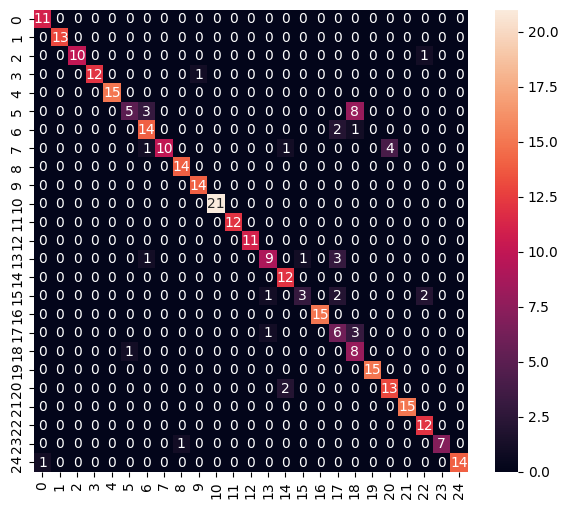

Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      1.00      1.00        13
           2       1.00      0.91      0.95        11
           3       1.00      0.92      0.96        13
           4       1.00      1.00      1.00        15
           5       0.83      0.31      0.45        16
           6       0.74      0.82      0.78        17
           7       1.00      0.62      0.77        16
           8       0.93      1.00      0.97        14
           9       0.93      1.00      0.97        14
          10       1.00      1.00      1.00        21
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00        11
          13       0.82      0.64      0.72        14
          14       0.80      1.00      0.89        12
          15       0.75      0.38      0.50         8
          16       1.00      1.00      1.00        15
     

In [14]:
# callback needs to be done better, but still accuracy 86%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [15]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      0.917     1.000     0.957        11
           1      1.000     1.000     1.000        13
           2      1.000     0.909     0.952        11
           3      1.000     0.923     0.960        13
           4      1.000     1.000     1.000        15
           5      0.833     0.312     0.455        16
           6      0.737     0.824     0.778        17
           7      1.000     0.625     0.769        16
           8      0.933     1.000     0.966        14
           9      0.933     1.000     0.966        14
          10      1.000     1.000     1.000        21
          11      1.000     1.000     1.000        12
          12      1.000     1.000     1.000        11
          13      0.818     0.643     0.720        14
          14      0.800     1.000     0.889        12
          15      0.750     0.375     0.500         8
          16      1.000     1.000     1.000        15
          17      0.462    

Text(0.5, 1.0, 'Loss')

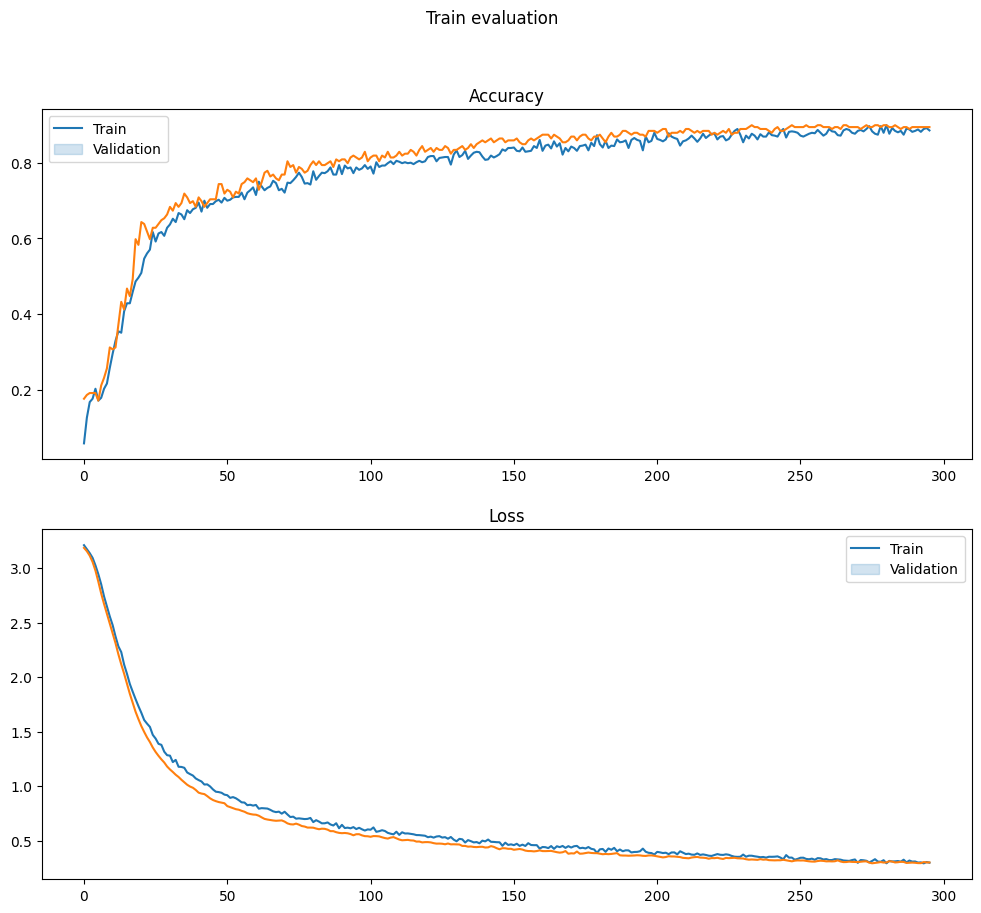

In [16]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
# xlabel("X axis label")
# ylabel("Y axis label")

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
# creating charts and plotting them

In [17]:
model_save_path = 'keypoint_classifier/LSTM_model_left_augmented.hdf5'
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1,2*21)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [18]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             18600     
                                                                 
 dropout_2 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
Total params: 81,525
Trainable params: 81,525
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
1/7 [===>..........................] - ETA: 12s - loss: 3.2194 - accuracy: 0.0312
Epoch 1: saving model to keypoint_classifier\LSTM_model_left_augmented.hdf5
7/7 [==============================] - 3s 87ms/step - loss: 3.2157 - accuracy: 0.0691 - val_loss: 3.2112 - val_accuracy: 0.1156
Epoch 2/500
1/7 [===>..........................] - ETA: 0s - loss: 3.2091 - accuracy: 0.1406
Epoch 2: saving model to keypoint_classifier\LSTM_model_left_augmented.hdf5
7/7 [==============================] - 0s 10ms/step - loss: 3.2058 - accuracy: 0.1332 - val_loss: 3.2021 - val_accuracy: 0.1256
Epoch 3/500
1/7 [===>..........................] - ETA: 0s - loss: 3.1941 - accuracy: 0.2109
Epoch 3: saving model to keypoint_classifier\LSTM_model_left_augmented.hdf5
7/7 [==============================] - 0s 10ms/step - loss: 3.1948 - accuracy: 0.1533 - val_loss: 3.1880 - val_accuracy: 0.1407
Epoch 4/500
1/7 [===>..........................] - ETA: 0s - loss: 3.1815 - accuracy: 0.1797
Epoch 4: saving

11/11 [==============================] - 1s 1ms/step


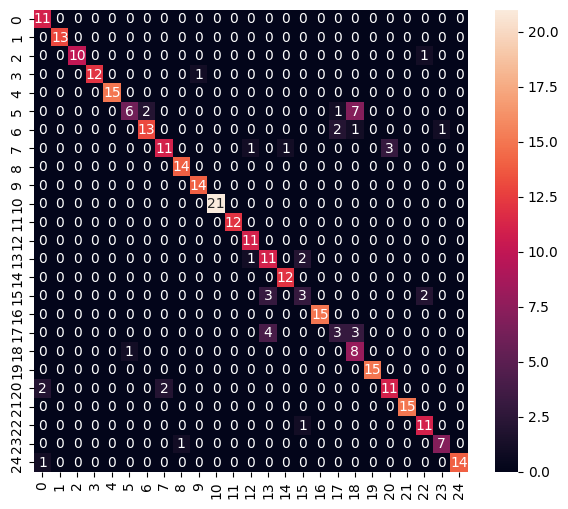

Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       1.00      1.00      1.00        13
           2       1.00      0.91      0.95        11
           3       1.00      0.92      0.96        13
           4       1.00      1.00      1.00        15
           5       0.86      0.38      0.52        16
           6       0.87      0.76      0.81        17
           7       0.85      0.69      0.76        16
           8       0.93      1.00      0.97        14
           9       0.93      1.00      0.97        14
          10       1.00      1.00      1.00        21
          11       1.00      1.00      1.00        12
          12       0.85      1.00      0.92        11
          13       0.61      0.79      0.69        14
          14       0.92      1.00      0.96        12
          15       0.50      0.38      0.43         8
          16       1.00      1.00      1.00        15
     

In [20]:
# callback needs to be done better, but still accuracy 86%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [21]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      0.786     1.000     0.880        11
           1      1.000     1.000     1.000        13
           2      1.000     0.909     0.952        11
           3      1.000     0.923     0.960        13
           4      1.000     1.000     1.000        15
           5      0.857     0.375     0.522        16
           6      0.867     0.765     0.812        17
           7      0.846     0.688     0.759        16
           8      0.933     1.000     0.966        14
           9      0.933     1.000     0.966        14
          10      1.000     1.000     1.000        21
          11      1.000     1.000     1.000        12
          12      0.846     1.000     0.917        11
          13      0.611     0.786     0.688        14
          14      0.923     1.000     0.960        12
          15      0.500     0.375     0.429         8
          16      1.000     1.000     1.000        15
          17      0.500    

Text(0.5, 1.0, 'Loss')

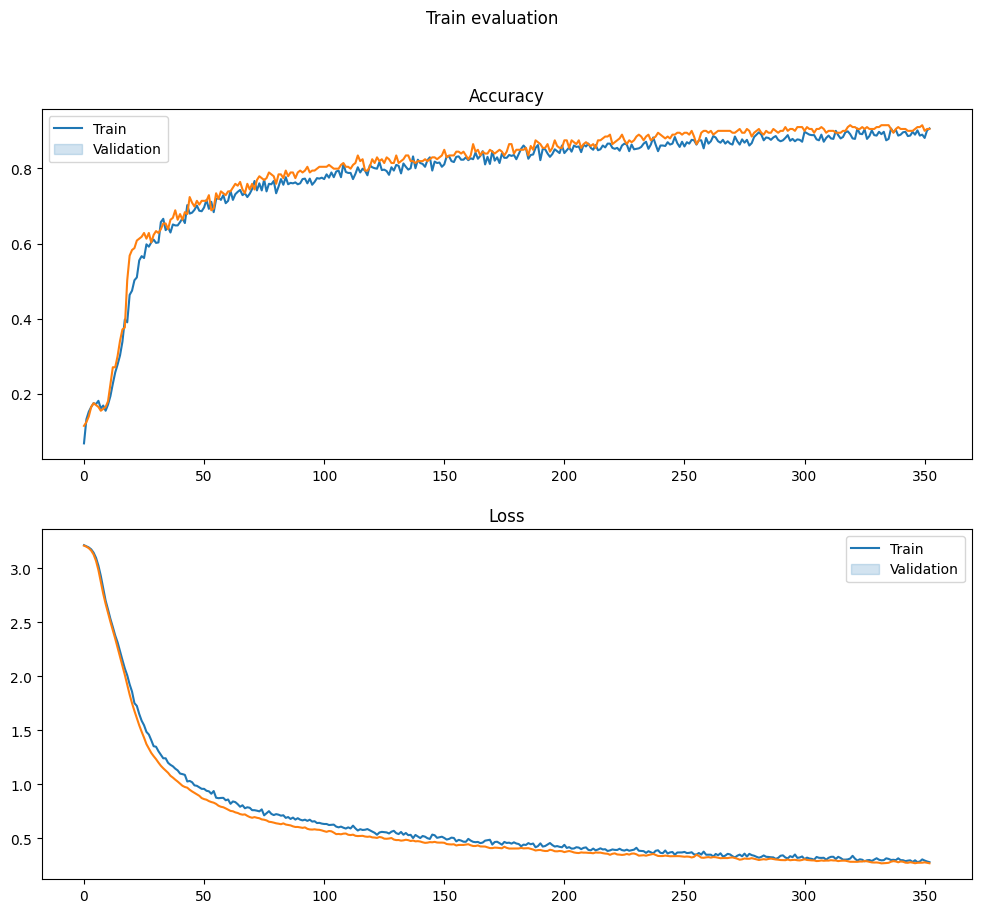

In [22]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
# xlabel("X axis label")
# ylabel("Y axis label")

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
# creating charts and plotting them

In [23]:
model_save_path = 'keypoint_classifier/SimpleRNN_model_left_augmented.hdf5'
from keras.layers import SimpleRNN
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(1,2*21)))
model.add(Dropout(0.2))
model.add(SimpleRNN(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [24]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 50)             4650      
                                                                 
 dropout_4 (Dropout)         (None, 1, 50)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               15100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
Total params: 22,275
Trainable params: 22,275
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
1/7 [===>..........................] - ETA: 6s - loss: 3.3396 - accuracy: 0.0312
Epoch 1: saving model to keypoint_classifier\SimpleRNN_model_left_augmented.hdf5
7/7 [==============================] - 1s 50ms/step - loss: 3.2870 - accuracy: 0.0339 - val_loss: 3.1422 - val_accuracy: 0.0553
Epoch 2/500
1/7 [===>..........................] - ETA: 0s - loss: 3.1700 - accuracy: 0.0312
Epoch 2: saving model to keypoint_classifier\SimpleRNN_model_left_augmented.hdf5
7/7 [==============================] - 0s 9ms/step - loss: 3.1174 - accuracy: 0.0791 - val_loss: 3.0077 - val_accuracy: 0.1457
Epoch 3/500
1/7 [===>..........................] - ETA: 0s - loss: 3.0249 - accuracy: 0.1250
Epoch 3: saving model to keypoint_classifier\SimpleRNN_model_left_augmented.hdf5
7/7 [==============================] - 0s 9ms/step - loss: 2.9788 - accuracy: 0.1344 - val_loss: 2.8761 - val_accuracy: 0.2412
Epoch 4/500
1/7 [===>..........................] - ETA: 0s - loss: 2.9180 - accuracy: 0.1484
Epo

11/11 [==============================] - 0s 921us/step


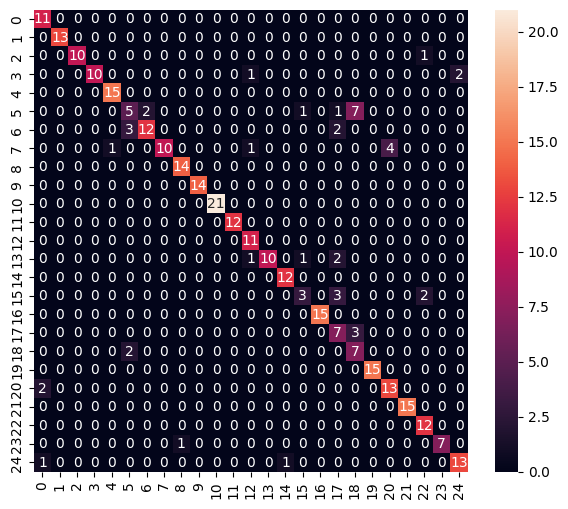

Classification Report
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       1.00      1.00      1.00        13
           2       1.00      0.91      0.95        11
           3       1.00      0.77      0.87        13
           4       0.94      1.00      0.97        15
           5       0.50      0.31      0.38        16
           6       0.86      0.71      0.77        17
           7       1.00      0.62      0.77        16
           8       0.93      1.00      0.97        14
           9       1.00      1.00      1.00        14
          10       1.00      1.00      1.00        21
          11       1.00      1.00      1.00        12
          12       0.79      1.00      0.88        11
          13       1.00      0.71      0.83        14
          14       0.92      1.00      0.96        12
          15       0.60      0.38      0.46         8
          16       1.00      1.00      1.00        15
     

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [27]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      0.786     1.000     0.880        11
           1      1.000     1.000     1.000        13
           2      1.000     0.909     0.952        11
           3      1.000     0.769     0.870        13
           4      0.938     1.000     0.968        15
           5      0.500     0.312     0.385        16
           6      0.857     0.706     0.774        17
           7      1.000     0.625     0.769        16
           8      0.933     1.000     0.966        14
           9      1.000     1.000     1.000        14
          10      1.000     1.000     1.000        21
          11      1.000     1.000     1.000        12
          12      0.786     1.000     0.880        11
          13      1.000     0.714     0.833        14
          14      0.923     1.000     0.960        12
          15      0.600     0.375     0.462         8
          16      1.000     1.000     1.000        15
          17      0.467    

Text(0.5, 1.0, 'Loss')

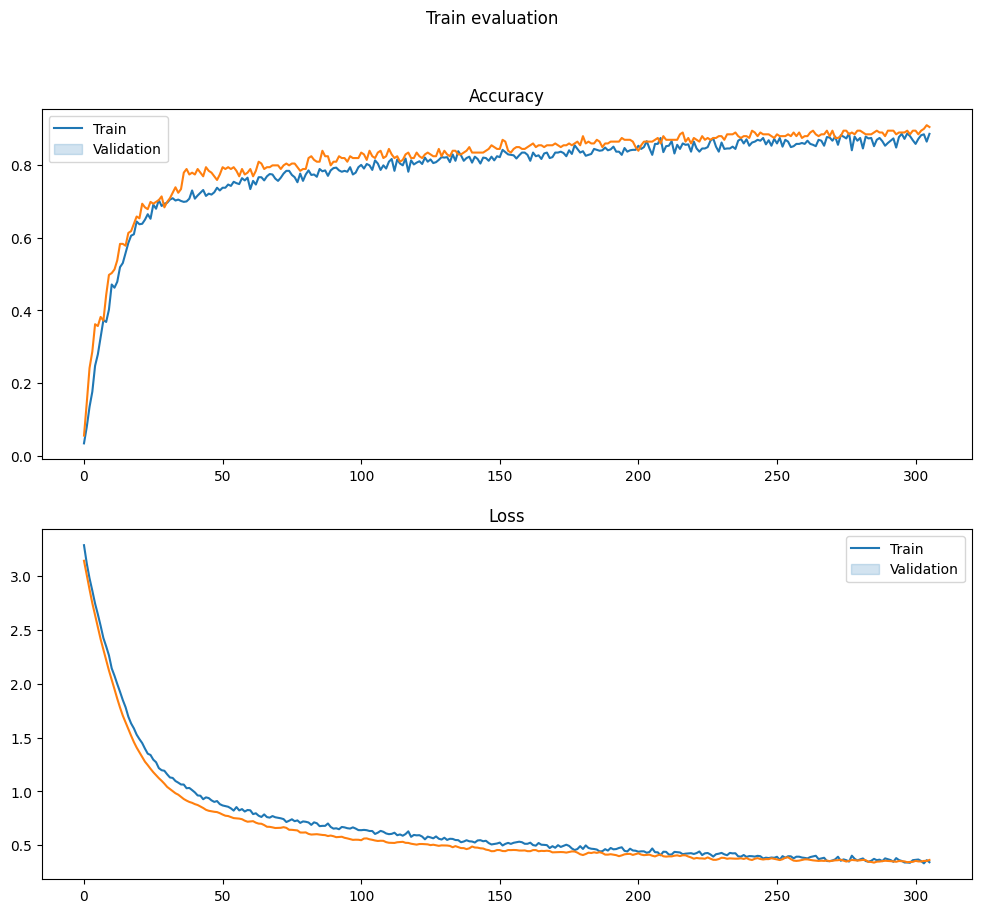

In [28]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
# xlabel("X axis label")
# ylabel("Y axis label")
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
# creating charts and plotting them

In [29]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [30]:
model_save_path = 'keypoint_classifier/FF_model_left_augmented.hdf5'
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.layers import GRU
model = Sequential()
model.add(Dense(256, input_shape=(42,), activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(NUM_CLASSES, activation="softmax"))

model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               11008     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 25)                3225      
                                                                 
Total params: 47,129
Trainable params: 47,129
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
1/7 [===>..........................] - ETA: 2s - loss: 3.2011 - accuracy: 0.1094
Epoch 1: saving model to keypoint_classifier\FF_model_left_augmented.hdf5
7/7 [==============================] - 1s 24ms/step - loss: 3.1613 - accuracy: 0.1055 - val_loss: 3.0441 - val_accuracy: 0.2714
Epoch 2/500
1/7 [===>..........................] - ETA: 0s - loss: 3.0291 - accuracy: 0.3203
Epoch 2: saving model to keypoint_classifier\FF_model_left_augmented.hdf5
7/7 [==============================] - 0s 8ms/step - loss: 2.9672 - accuracy: 0.3342 - val_loss: 2.8589 - val_accuracy: 0.3467
Epoch 3/500
1/7 [===>..........................] - ETA: 0s - loss: 2.8158 - accuracy: 0.4297
Epoch 3: saving model to keypoint_classifier\FF_model_left_augmented.hdf5
7/7 [==============================] - 0s 8ms/step - loss: 2.7713 - accuracy: 0.3769 - val_loss: 2.6411 - val_accuracy: 0.3065
Epoch 4/500
1/7 [===>..........................] - ETA: 0s - loss: 2.6052 - accuracy: 0.3906
Epoch 4: saving model to

11/11 [==============================] - 0s 1ms/step


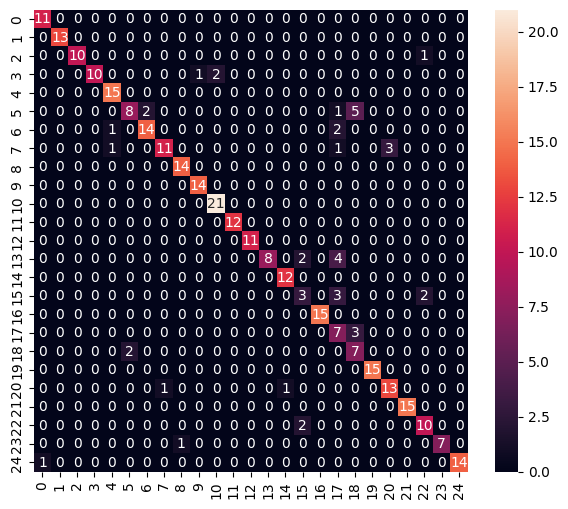

Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      1.00      1.00        13
           2       1.00      0.91      0.95        11
           3       1.00      0.77      0.87        13
           4       0.88      1.00      0.94        15
           5       0.80      0.50      0.62        16
           6       0.88      0.82      0.85        17
           7       0.92      0.69      0.79        16
           8       0.93      1.00      0.97        14
           9       0.93      1.00      0.97        14
          10       0.91      1.00      0.95        21
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00        11
          13       1.00      0.57      0.73        14
          14       0.92      1.00      0.96        12
          15       0.43      0.38      0.40         8
          16       1.00      1.00      1.00        15
     

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [33]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      0.917     1.000     0.957        11
           1      1.000     1.000     1.000        13
           2      1.000     0.909     0.952        11
           3      1.000     0.769     0.870        13
           4      0.882     1.000     0.938        15
           5      0.800     0.500     0.615        16
           6      0.875     0.824     0.848        17
           7      0.917     0.688     0.786        16
           8      0.933     1.000     0.966        14
           9      0.933     1.000     0.966        14
          10      0.913     1.000     0.955        21
          11      1.000     1.000     1.000        12
          12      1.000     1.000     1.000        11
          13      1.000     0.571     0.727        14
          14      0.923     1.000     0.960        12
          15      0.429     0.375     0.400         8
          16      1.000     1.000     1.000        15
          17      0.389    

Text(0.5, 1.0, 'Loss')

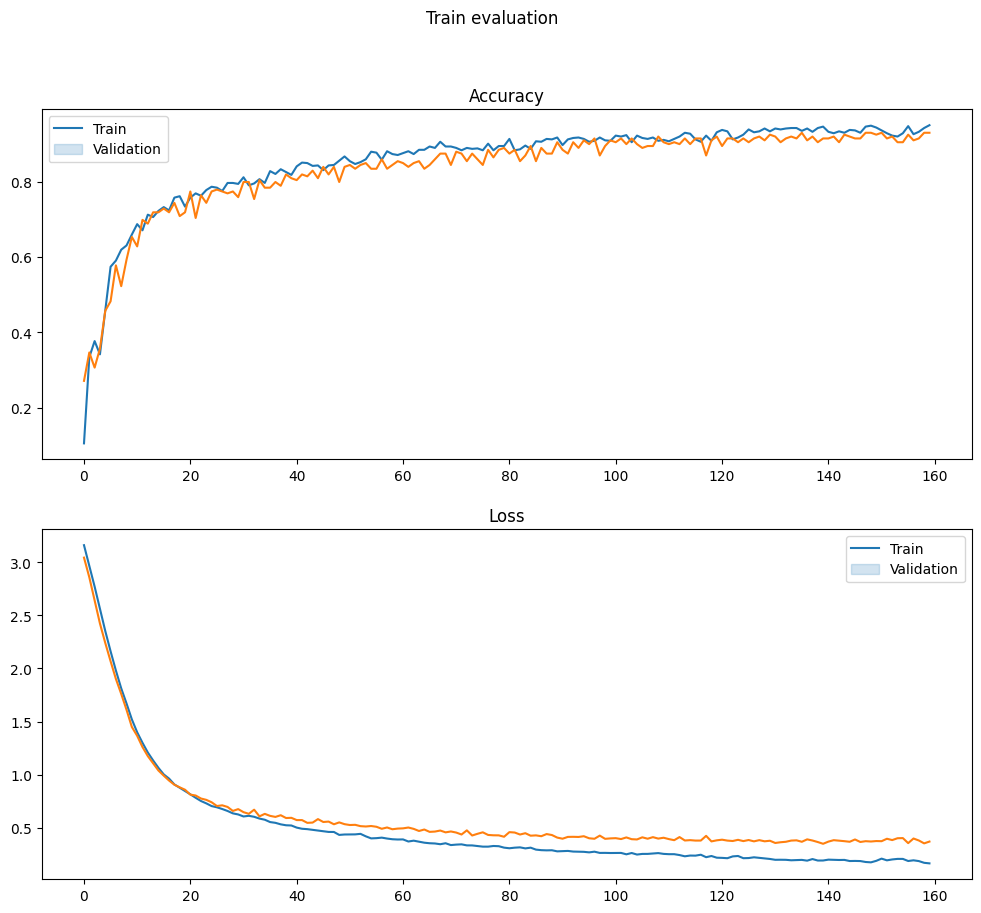

In [34]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
# xlabel("X axis label")
# ylabel("Y axis label")

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
# creating charts and plotting them